## Variant Calling Report v1.2.3
## Input Parameters

In [1]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
import nexusplt as nxp
from configparser import ConfigParser

pd.options.display.float_format = '{:,.2%}'.format
pd.set_option('display.max_colwidth', None)

configFile='var_report.config'
parser = ConfigParser()
parser.read(configFile)

prmNames=['run_id','pipeline_version',
          'h5_concordance_file', 'h5_model_file',
          'model_name_with_gt','model_name_without_gt','model_pkl_with_gt','model_pkl_without_gt'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('VarReport', name)

h5outfile = parser.get('VarReport', 'h5_output', fallback='var_report.h5')
imgpref = parser.get('VarReport', 'image_output_prefix', fallback=prm['run_id']+'.vars')+'.'
imgdir = 'plots'

sources = {'Trained wo gt':(prm['h5_concordance_file'],"concordance"),
           'Trained with gt':(prm['h5_model_file'],"scored_concordance"),
          }

data = {}
for s in sources:
    data[s]={}
    d=pd.read_hdf(sources[s][0], key=sources[s][1], mode='r')
    data[s]=d

# Load the concordance data for the entire genome
with pd.HDFStore(prm['h5_concordance_file']) as hdf:
    keys=hdf.keys()
    keys=["chr9","chr19"] #remove after dev is done
    wg_dfs=[pd.read_hdf(hdf,k) for k in keys if k not in ['/concordance','/input_args']]
    wg_df=pd.concat(wg_dfs)
    
data['whole genome'] = wg_df
sources['whole genome'] = (prm['h5_concordance_file'],"all")
    
prm['mean_var_depth']='{:.2f}'.format(data['Trained wo gt']['well_mapped_coverage'].mean())
prmNames.append('mean_var_depth')
   
try:
    args=pd.read_hdf(sources['Trained wo gt'][0], 'input_args', mode='r')
    prm['truth_sample_name']=args['truth_sample_name'][0]
except:
    prm['truth_sample_name']=parser.get('VarReport', 'truth_sample_name', fallback='NA')
prmNames.append('truth_sample_name')


prmdf = pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)
prmdf.to_hdf(h5outfile, key="parameters")

prmdf

,value
run_id,002111-X0003
pipeline_version,3.2.3
h5_concordance_file,002111-X0003.comp.h5
h5_model_file,002111-X0003.model.h5
model_name_with_gt,threshold_model_ignore_gt_incl_hpol_runs
model_name_without_gt,rf_model_ignore_gt_incl_hpol_runs
model_pkl_with_gt,002111-X0003.model.wgt.pkl
model_pkl_without_gt,002111-X0003.model.nogt.pkl
mean_var_depth,49.02
truth_sample_name,HG01204


In [2]:
def filterByCategory(data,cat):
    if cat=='SNP':
        return data[data['indel']==False]
    if cat=='Indel':
        return data[data['indel']==True]
    elif cat=='non-hmer Indel':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0)]
    elif cat=='non-hmer Indel w/o LCR':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0) & 
                    (~data['LCR-hs38'])]
    elif cat=='hmer Indel <=4':
        return data[(data['indel']==True) & (data['hmer_indel_length']>0) & (data['hmer_indel_length']<=4)]
    elif cat=='hmer Indel >4,<=8':
        return data[(data['indel']==True) & (data['hmer_indel_length']>4) & (data['hmer_indel_length']<=8)]
    elif cat=='hmer Indel >8,<=10':
        return data[(data['indel']==True) & (data['hmer_indel_length']>8) & (data['hmer_indel_length']<=10)]
    for i in range (1,10):
        if cat=='hmer Indel {0:d}'.format(i):
            return data[(data['indel']==True) & (data['hmer_indel_length']==i)]
    return None


In [3]:
def calcPerformance(data):
    classify_col='classify_gt' 
    d=data.copy()
    
    # Calculate precision and recall continuously along the tree_score values
    d['tree_score'] = np.where(d[classify_col]=='fn',-1,d['tree_score'])
    d=d[[classify_col,'tree_score','filter']].sort_values(by=['tree_score'])
    
    d['label'] = np.where(d[classify_col]=='fp',0,1)

    d.loc[d['filter']=='HPOL_RUN','filter']='PASS'
    d.loc[d[classify_col]=='fn','filter']='MISS'

    num=len(d)
    numPos=sum(d['label'])
    numNeg=num-numPos
    if num<10:
        return (pd.DataFrame(),None,numPos,numNeg)
    
    d['fn']=np.cumsum(d['label'])
    d['tp']=numPos-(d['fn'])
    d['fp']=numNeg-np.cumsum(1-d['label'])

    d['recall']=d['tp']/(d['tp']+d['fn'])
    d['precision']=d['tp']/(d['tp']+d['fp'])

    d['f1']=d['tp']/(d['tp']+0.5*d['fn']+0.5*d['fp'])

    d['mask']=((d['tp']+d['fn'])>=20) & ((d['tp']+d['fp'])>=20) & (d['tree_score']>=0)
    if len(d[d['mask']])==0:
        return (pd.DataFrame(),None,numPos,numNeg)

    # Calculate the precision and recall as ouputted by the model (based on the FILTER column)
    d['class'] = np.where(d['label']==0,'FP','FN')
    d.loc[(d['label']==1) & (d['filter']=='PASS'),'class']='TP'
    d.loc[(d['label']==0) & (d['filter']!='PASS'),'class']='TN'

    fn=len(d[d['class']=='FN'])
    tp=len(d[d['class']=='TP'])
    fp=len(d[d['class']=='FP'])

    recall=tp/(tp+fn) if (tp+fn>0) else np.nan
    precision=tp/(tp+fp) if (tp+fp>0) else np.nan
    max_recall=1-len(d[d['filter']=='MISS'])/numPos

    f1=tp/(tp+0.5*fn+0.5*fp)
    
    return (d[['recall','precision']][d['mask']],
            dict({'recall':recall,'precision':precision,'f1':f1}),
            numPos,numNeg)



In [18]:
def plotPerformance(perfCurve,optRes,categories,source=sources,ext=None,img=None,legend=None,optRes_SEC=None):
    n=len(categories)
    nrow=int(np.ceil(n/5))
    ncol=int(max(5,n))
    fig, ax = plt.subplots(nrow,ncol) #figsize=(4*nrow,4*ncol)
    
    col=['r','b','g','m','k']

    for i,cat in enumerate(categories):
        for j,s in enumerate(source):
            perf=perfCurve[s][cat]
            opt=optRes[s][cat]
            opt_sec=optRes_SEC[s][cat]
            if not perf.empty:
                ax[i].plot(perf.recall,perf.precision,'-',label=s,color=col[j])    
                ax[i].plot(opt.get('recall'),opt.get('precision'),'o',color=col[j])
                if optRes_SEC is not None:
                    ax[i].plot(opt_sec.get('recall'),opt_sec.get('precision'),'o',color="black")
            title=cat if ext==None else '{0} ({1})'.format(cat,ext)
            ax[i].set_title(title)
            ax[i].set_xlabel("Recall")
            ax[i].set_xlim([0.4,1])
            ax[i].set_ylim([0.4,1])
            ax[i].grid(True)

    ax[0].set_ylabel("Precision")
    if legend: 
        ax[0].legend(loc='lower left')    
    if img:
        nxp.save(fig,imgpref+img,'png',outdir=imgdir)
    
    
def getPerformance(data,categories):
    optTab={}
    optRes={}
    perfCurve={}
    for s in sources:
        optTab[s]=pd.DataFrame()
        optRes[s]={}
        perfCurve[s]={}

        for i,cat in enumerate(categories):
            d=filterByCategory(data[s],cat)
            perf,opt,pos,neg=calcPerformance(d)
            perfCurve[s][cat]=perf
            optRes[s][cat]=opt
            
            row=pd.DataFrame({'# pos':pos,
                              '# neg':neg,
                              'max recall':np.nan if perf.empty else max(perf.recall),
                              'recall':np.nan if perf.empty else opt.get('recall'),
                              'precision':np.nan if perf.empty else opt.get('precision'),
                              'F1':np.nan if perf.empty else opt.get('f1')
                             },index=[cat])
            optTab[s]=pd.concat([optTab[s],row])
            
    return optTab,optRes,perfCurve

## Performance over all Data

In [6]:
def has_sec(x):
    res = False
    if x is not None:
        if x==x:
            if "SEC" in x:
                res=True
    return res

sec_df = data['whole genome'].copy()
is_sec = sec_df['blacklst'].apply(has_sec)
sec_df.loc[is_sec,'filter'] = "SEC"
sec_df.loc[(is_sec) & (sec_df['classify_gt']=='tp'),'classify_gt'] = "fn"
sec_df_new=sec_df[~((is_sec) & (sec_df['classify_gt']=='fp'))]
#sec_df.loc[(is_sec) & (sec_df['classify_gt']=='fp'),'classify_gt'] = "tn"

data_SEC={'whole genome': sec_df_new,'Trained wo gt':data['Trained wo gt'].copy(), 'Trained with gt':data['Trained with gt'].copy()}
#data_SEC['whole genome']['classify_gt'].value_counts()

#out_df=sec_df[(is_sec) & (sec_df['classify_gt']=='fp')]
#out_df[(out_df['indel']==True) & (out_df['hmer_indel_length']>0) & (out_df['hmer_indel_length']<=4)]


In [7]:
data_SEC['whole genome']['classify_gt'].value_counts()

tp    195341
fn      2924
fp      1832
Name: classify_gt, dtype: int64

In [8]:
data['whole genome']['classify_gt'].value_counts()

tp    195425
fp      7753
fn      2840
Name: classify_gt, dtype: int64

In [9]:
categories=['SNP','Indel','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(data,categories)
SEC_optTab1,SEC_optRes,SEC_perfCurve=getPerformance(data_SEC,categories)

In [10]:
pd.concat([optTab1['whole genome'],SEC_optTab1['whole genome']], axis=1)

,# pos,# neg,max recall,recall,precision,F1,# pos,# neg,max recall,recall,precision,F1
SNP,181187,938,99.68%,99.61%,99.74%,99.68%,181187,596,99.67%,99.60%,99.79%,99.69%
Indel,17078,6815,86.72%,85.43%,92.98%,89.04%,17078,1236,86.39%,85.12%,96.14%,90.29%
non-hmer Indel,8454,1132,95.78%,95.10%,96.65%,95.87%,8454,425,95.71%,95.03%,97.67%,96.33%
non-hmer Indel w/o LCR,6995,968,97.97%,97.57%,97.10%,97.33%,6995,332,97.94%,97.54%,98.10%,97.82%
hmer Indel <=4,2902,4267,98.97%,97.35%,92.44%,94.83%,2902,321,98.90%,97.28%,98.47%,97.87%
"hmer Indel >4,<=8",2020,710,98.07%,96.44%,94.93%,95.68%,2020,92,97.77%,96.19%,98.33%,97.25%


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

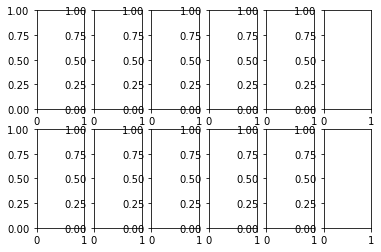

In [19]:
plotPerformance(perfCurve,optRes,categories,img='all.primary',source={'whole genome':sources['whole genome']},optRes_SEC=SEC_optRes)

In [ ]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.hmers',source={'whole genome':sources['whole genome']})

In [ ]:
pd.options.display.float_format = '{:,.2%}'.format

optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="all_data")

df['whole genome']

### Homozygous genotyping accuracy

The precision and recall of called homozygous variants (where the variant was not classfied as False Negative)

In [15]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']

hmzData={}
for s in sources:
        d=data[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories,gt=True)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="all_data_homozygous")

df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP,66215,0,99.94%,99.93%,100.00%,99.96%
non-hmer Indel,2679,2,98.25%,98.13%,99.92%,99.02%
non-hmer Indel w/o LCR,2348,1,99.02%,99.06%,99.96%,99.51%
hmer Indel <=4,1144,0,99.56%,99.56%,100.00%,99.78%
"hmer Indel >4,<=8",680,0,99.41%,99.41%,100.00%,99.71%


## Performance over UG high confidence regions

In [ ]:
filtData={}
for s in sources:
    d=data[s]
    filtData[s]=d.query("ug_hcr==True")

categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.primary',source={'whole genome':sources['whole genome']})

In [ ]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.hmers',source={'whole genome':sources['whole genome']})

In [ ]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="ug_hcr")
defTable=df.copy()
df['whole genome']

### Homozygous genotyping accuracy

In [ ]:
categories=['SNP','non-hmer Indel','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10']

hmzData={}
for s in sources:
        d=filtData[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories,gt=True)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="ug_hcr_homozygous")
df['whole genome']

### Stratified by base

#### (A,T)

In [ ]:
categories=['SNP','non-hmer Indel','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10']

baseData={}
b =('A','T')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab1,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab1[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab1[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

#### (G,C)

In [ ]:
categories=['SNP','non-hmer Indel','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10']
baseData={}
b =('C','G')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab2,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab2[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab2[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

In [ ]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="ug_hcr_per_base")
df['whole genome']

## Performance over regions with coverage>=20 and mappability.0

In [ ]:
filtData={}
for s in sources:
    d=data[s]
    filtData[s]=d[(d['well_mapped_coverage']>=20) &
                  (d['mappability.0'])
                 ]

categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.primary',source={'whole genome':sources['whole genome']})


In [ ]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.hmers',source={'whole genome':sources['whole genome']})

In [ ]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data")
defTable=df.copy()
df['whole genome']

### Including genotype

In [ ]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab,optRes,perfCurve=getPerformance(filtData,categories,gt=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

In [ ]:
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_gt")
df['whole genome']

### Homozygous genotyping accuracy

In [ ]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']

hmzData={}
for s in sources:
        d=filtData[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify_gt']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories,gt=True)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_homozygous")
df['whole genome']

### Stratified by base

#### (A,T)

In [ ]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10','hmer Indel 8']

baseData={}
b =('A','T')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab1,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab1[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab1[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

#### (G,C)

In [ ]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10','hmer Indel 6']
baseData={}
b =('C','G')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab2,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab2[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab2[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

In [ ]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_per_base")
df['whole genome']

## Performance over regions with coverage>=20 and mappability.0

In [ ]:
filtData={}
for s in sources:
    d=data[s]
    filtData[s]=d[(d['well_mapped_coverage']>=20) &
                  (d['mappability.0'])
                 ]

categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.primary',source={'whole genome':sources['whole genome']})


In [ ]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.hmers',source={'whole genome':sources['whole genome']})

In [ ]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data")
defTable=df.copy()
df['whole genome']

### Including genotype

In [ ]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab,optRes,perfCurve=getPerformance(filtData,categories,gt=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

In [ ]:
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_gt")
df['whole genome']

### Homozygous genotyping accuracy

In [ ]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']

hmzData={}
for s in sources:
        d=filtData[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories,gt=True)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_homozygous")
df['whole genome']

### Stratified by base

#### (A,T)

In [ ]:
categories=['SNP','non-hmer Indel','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10']

baseData={}
b =('A','T')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab1,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab1[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab1[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

#### (G,C)

In [ ]:
categories=['SNP','non-hmer Indel','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10']
baseData={}
b =('C','G')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab2,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab2[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab2[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

In [ ]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_per_base")
df['whole genome']

###  Trained with and without Ground Truth

<ul>
<li><b>Trained wo gt - Trained without ground truth </b></li>
Random forest model trained on chromosome 9 using known variants in dbSNP and on common fp variants
<li><b>Trained with gt - Trained with ground truth</b></li>
Simple threshold model trained on chromosome 9 using its own ground truth
</ul>

In [ ]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.primary',source={'Trained wo gt':sources['Trained wo gt'], 'Trained with gt': sources['Trained wo gt']},legend=sources[s])

In [ ]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.hmers',source={'Trained wo gt':sources['Trained wo gt'], 'Trained with gt': sources['Trained wo gt']},legend=sources[s])

In [ ]:
pd.options.display.float_format = '{:,.2%}'.format
sources={'Trained wo gt':sources['Trained wo gt'], 'Trained with gt': sources['Trained wo gt']}
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="trained_w_wo_gt")
df_all=df
df

In [ ]:
%matplotlib agg
d=defTable['Trained with gt'][['max recall','recall','precision']]
labels=['SNP','nhmer','nhmer w/o LCR','hmer 2-4','hmer 5-8','hmer 4','hmer 5','hmer 6','hmer 7','hmer 8','hmer 9-10']
fig=plt.figure()
ax=d.plot()
plt.xticks(np.arange(len(d.index)), rotation=30, ha='right')
ax.set_xticklabels(labels)
plt.ylim([0.4,1.05])
plt.grid()
plt.title('Cvg>20X, Trained variant calls')
plt.tight_layout()
nxp.save(fig,imgpref+'summary','png',outdir=imgdir)
plt.close(fig)